In [1]:
import numpy as np

from scipy.interpolate import Rbf, interp1d
from scipy.integrate import quad
import matplotlib.pylab as plt

import ghalton

from fakequadrature import quadrature_weights

In [2]:
f=lambda x: 1/(1+4*x**2)
a,b = -2,2

In [3]:
I_True, _ = quad(f,a,b, epsabs = 1.e-10)

In [4]:
rbf = lambda self,r: np.exp(-self.epsilon*r)*(1+self.epsilon*r)
ep = 5.e-1

In [5]:
deg = 40

In [6]:
Degrees = np.arange(1,42,2)

In [7]:
errCL, errH, err1, err2 = [], [], [], []
for deg in Degrees:
    n = int(deg + 1)

    # Halton nodes in [-2,2]
    G = ghalton.GeneralizedHalton(1, n-2)
    x = 4 * np.array([0.]+ sorted([a[0] for a in G.get(n-2)]) + [1.]) - 2
    y = f(x)
    # Chebyshev-Lobatto nodes in [-2,2]
    xCL = -(b-a)/2*np.cos(np.arange(0,deg+1)*np.pi/deg)+(a+b)/2
    yCL = f(xCL)


    S1 = Rbf(x, xCL, function=rbf, epsilon = ep)
    S2 = interp1d(x, xCL, kind = 'linear')

    # quadrature on CL nodes
    wCL = quadrature_weights(xCL,(a,b))
    ICL = np.dot(wCL, yCL)
    errCL.append(np.abs(I_True - ICL))

    # quadrature on Halton Nodes
    wH = quadrature_weights(x,(a,b))
    IH = np.dot(wH, y)
    errH.append(np.abs(I_True - IH))

    # quadrature on Fake-CL nodes
    w1 = quadrature_weights(x,(a,b), mapping=S1)
    I1 = np.dot(w1,y)
    err1.append(np.abs(I_True - I1))

    w2 = quadrature_weights(x,(a,b), mapping=S2)
    I2 = np.dot(w2,y)
    err2.append(np.abs(I_True - I2))

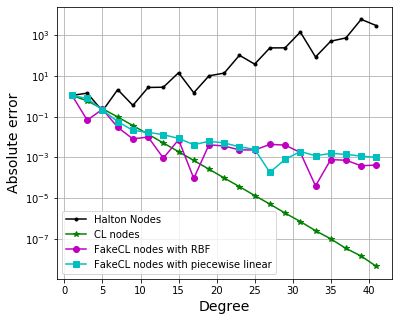

In [9]:
fig, ax = plt.subplots(1, 1,figsize=(6,5))

asc = list(Degrees)
ax.semilogy(asc,errH,'.-k',asc,errCL,
            '*-g',asc,err1,'o-m',asc,err2,'s-c')
ax.set_xlabel("Degree", fontsize = 14)
ax.set_ylabel("Absolute error", fontsize = 14)
ax.legend(["Halton Nodes", "CL nodes", "FakeCL nodes with RBF",
           "FakeCL nodes with piecewise linear"])
ax.grid(True)
plt.savefig("figRunge.pdf")
plt.show()